# Assignment 11 - Reference solution

In [1]:
#from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.linalg as la

## Generating training data

In [2]:
N=31

X_train = np.zeros((N*N,2))
X_1, X_2 = np.meshgrid(np.linspace(-4,4,N),np.linspace(-4,4,N))
X_train[:,0] = X_1.flatten()
X_train[:,1] = X_2.flatten()
y_train = np.zeros(N*N)
y_train = y_train.reshape(-1,1)

def f(x, y):
     return (np.sin(np.sqrt((0.5*x) ** 2 + (0.5*y) ** (4))))

y_train =  f(X_train[:,0],X_train[:,1])
y_train = y_train.reshape(-1,1)

## Algorithm 17: Kernel ridge regression (Gaussian kernel)

In [3]:
def rbf_kernel(x, y, gamma:float):
    """Calculates rbf kernel value between two vectors x and y.
    Args:
        x: vector/float
        y: vector/float
        gamma: (2 * σ**2)_inverse
    """
    assert len(x) == len(y)
    return np.exp(-np.dot(x-y, x-y) * gamma)
    
def rbf_kernel_matrix_self(X, gamma: float):
    """Returns rbf kernel matrix of X with self."""
    num_samples = X.shape[0]
    kernel_mat = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if j>i:
                break
            kernel_mat[i,j] = rbf_kernel(X[i], X[j], gamma)
            kernel_mat[j,i] = kernel_mat[i,j]
    return kernel_mat

def rbf_kernel_matrix_pairwise(X1, X2, gamma: float):
    """Computes rbf kernel matrix between two matrices with different num of rows(samples) but same number of 
    features(columns).
    """
    assert X1.shape[1] == X2.shape[1]
    num_samples_X1 = X1.shape[0]
    num_samples_X2 = X2.shape[0]
    kernel_mat = np.zeros((num_samples_X1, num_samples_X2))
    for i in range(num_samples_X1):
        for j in range(num_samples_X2):
            kernel_mat[i,j] = rbf_kernel(X1[i], X2[j], gamma)
    return kernel_mat


In [4]:
def kernel_ridge_regression_fit(X_train, y_train, gamma, lamda):
    """Fits linear regression model on training data. Minimizes gradient of cost function using closed form approach."""
    A = rbf_kernel_matrix_self(X_train, gamma)
    I = np.identity(X_train.shape[0])
                                                        #Solve (A + λI)α = y using cholesky factorization for α
    c, low = la.cho_factor(A + lamda*I)
    α = la.cho_solve((c, low), y_train)
    return α

def kernel_ridge_regression_predict(α, X_train, X_predict, gamma):
    """Predicts output for X feature matrix using fitted LR parameters ß."""
    kernel_mat_pairwise = rbf_kernel_matrix_pairwise(X_predict, X_train, gamma)
    return np.dot(kernel_mat_pairwise, α)

def kernel_ridge_regression(X_train, y_train, X_predict, gamma, lamda):
    """Performs kernel ridge regression.
    Args:
        X_train: feature matrix for training the model.
        y_train: array of training output.
        X_predict: feature matrix for prediction.
        gamma: inverse of variance of gaussian kernel
        lamda: regularization parameter.
    Returns:
        predictions: array of predicted outputs.
    """
    weights = kernel_ridge_regression_fit(X_train, y_train, gamma, lamda)
    predictions = kernel_ridge_regression_predict(weights, X_train, X_predict, gamma)
    return predictions

## Test data and visualization of predictions:

In [7]:
N_eval = 150
x_1 = np.linspace(-4.2,4.2,N_eval)
x_2 = np.linspace(-4.2,4.2,N_eval)
X_1, X_2 = np.meshgrid(x_1,x_2)
X_eval = np.zeros((N_eval**2,2))
X_eval[:,0] = X_1.flatten()
X_eval[:,1] = X_2.flatten()

Y_eval = kernel_ridge_regression(X_train, y_train, X_eval, gamma=0.15, lamda=0.001)

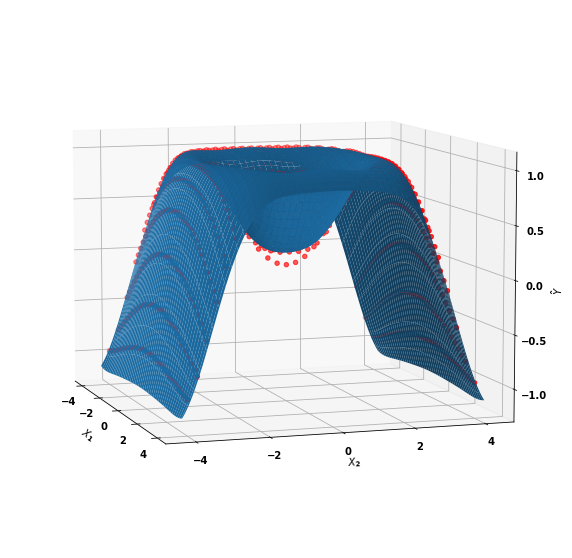

In [8]:
pos = np.empty(X_1.shape + (2,))
pos[:, :, 0] = X_1; pos[:, :, 1] = X_2
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1],y_train[:],c='red', label="training set")
ax.plot_surface(X_1,X_2,Y_eval.reshape(N_eval,N_eval), label="regression predictor")
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_zlabel("$\hat{Y}$")
ax.view_init(elev=8., azim=-18)
plt.show()